In [3]:
# =======================
# 1. Install dependencies
# =======================
!pip install -q kaggle pytorch-lightning efficientnet_pytorch opencv-python-headless

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 51.8 MB/s eta 0:00:00

In [4]:
# ================================
# 2. Upload your Kaggle API key
# ================================
from google.colab import files
files.upload()   # <-- Upload kaggle.json from your Kaggle account

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paritoshsharma25","key":"26209822faa8fa84b6fd879e093a0202"}'}

In [5]:
# ================================
# 3. Set up Kaggle & Download Data
# ================================
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download Plant Seedlings Classification dataset
!kaggle competitions download -c plant-seedlings-classification
!unzip -q plant-seedlings-classification.zip -d data/

100% 1.68G/1.69G [00:14<00:00, 303MB/s]
100% 1.69G/1.69G [00:14<00:00, 121MB/s]


In [6]:
# =======================
# 1. Check Data Structure
# =======================
import os

data_path = 'data/train'
classes = sorted(os.listdir(data_path))
print(f"Found {len(classes)} plant species (classes):")
print(classes)

# Show number of images per class
for cls in classes:
    n_imgs = len(os.listdir(os.path.join(data_path, cls)))
    print(f"{cls}: {n_imgs} images")

Found 12 plant species (classes):
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


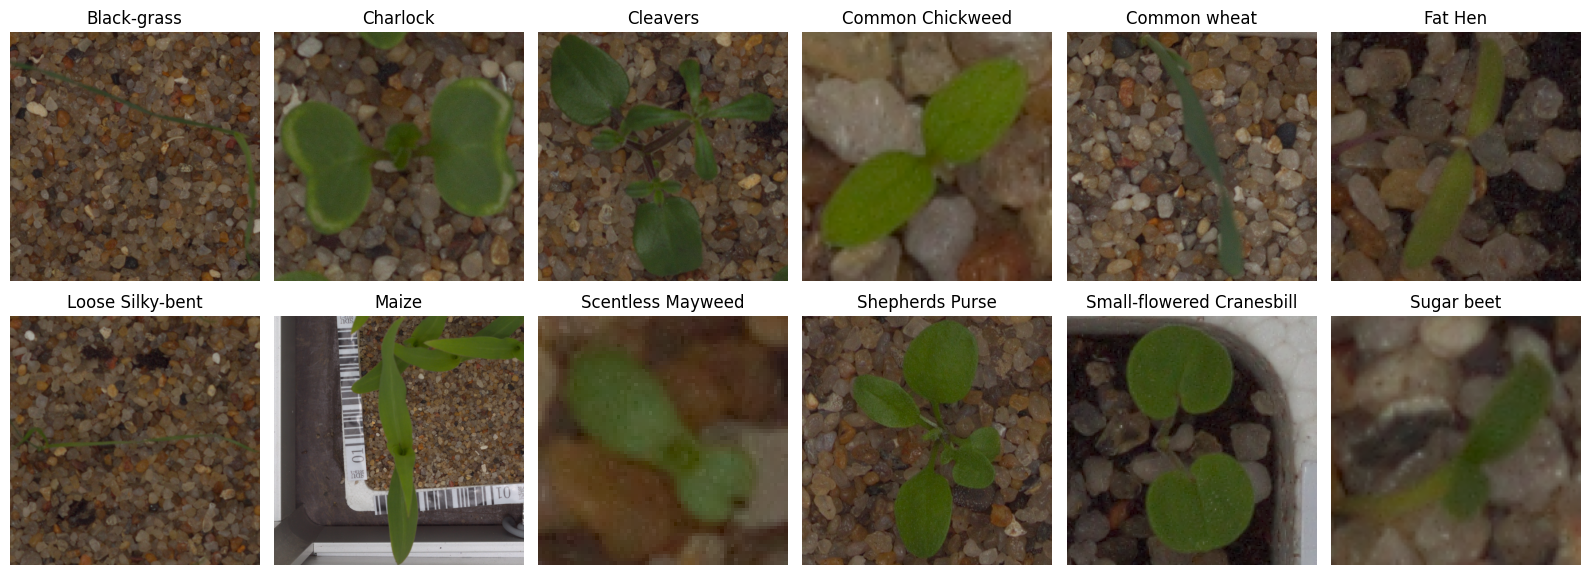

In [7]:
# =======================
# 2. Show Example Images
# =======================
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(2, 6, figsize=(16, 6))
for idx, cls in enumerate(classes[:12]):
    img_path = os.path.join(data_path, cls, os.listdir(os.path.join(data_path, cls))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[idx//6, idx%6].imshow(img)
    axs[idx//6, idx%6].set_title(cls)
    axs[idx//6, idx%6].axis('off')
plt.tight_layout()
plt.show()

In [8]:
import os
import shutil
import random
from tqdm import tqdm

# Set seed for reproducibility
random.seed(42)

original_data_dir = 'data/train'
split_base = 'data/split'
train_dir = os.path.join(split_base, 'train')
val_dir = os.path.join(split_base, 'val')

In [9]:
# Create split directories
for split_dir in [train_dir, val_dir]:
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# Split ratio (e.g., 85% train, 15% val)
split_ratio = 0.85

In [10]:
# For each class, shuffle and split images
for cls in tqdm(os.listdir(original_data_dir), desc="Splitting data by class"):
    cls_folder = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_folder)
    random.shuffle(images)
    n_train = int(len(images) * split_ratio)
    train_imgs = images[:n_train]
    val_imgs = images[n_train:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(val_dir, cls, img))

print("Splitting complete!")

Splitting data by class: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

Splitting complete!


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl

# Mean/std calculated from ImageNet; fine for transfer learning
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class PlantSeedlingsDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=2, img_size=224):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

    def setup(self, stage=None):
        # Training transforms: augment
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
        # Validation: center crop only
        self.val_transforms = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "train"), self.train_transforms)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "val"), self.val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)


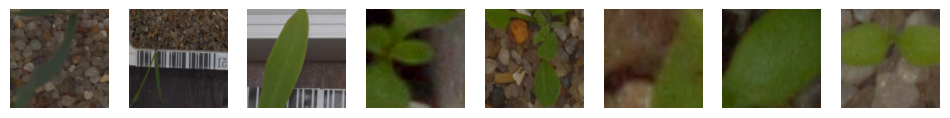

In [12]:
# Usage example:
data_module = PlantSeedlingsDataModule(data_dir='data/split', batch_size=32, num_workers=2)
data_module.setup()

batch = next(iter(data_module.train_dataloader()))
images, labels = batch
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Implementing CNN


In [13]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision import models

class CNNClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # Define CNN architecture
        self.model = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Classifier
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256*14*14, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        acc = (outputs.argmax(1) == targets).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Count classes
num_classes = len(os.listdir('data/split/train'))

# Create data module (remove unsupported parameters)
data_module = PlantSeedlingsDataModule(
    data_dir='data/split',
    batch_size=64,
    num_workers=4
)

# Define CNN model
model = CNNClassifier(num_classes=num_classes, lr=1e-3)

# Callbacks (optimized)
checkpoint_cb = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    save_top_k=1,
    filename='cnn-best'
)
early_stop_cb = EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode='max'
)

# Optimized trainer
trainer = pl.Trainer(
    max_epochs=25,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_cb, early_stop_cb],
    precision=16,  # mixed precision, faster on GPU
    log_every_n_steps=50,
    enable_checkpointing=True,  # Enable checkpointing
    gradient_clip_val=1.0,  # Gradient clipping for stability
    deterministic=False,  # Faster training (non-deterministic)
)

Using device: Tesla T4


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 26.1 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.345   Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7875000238418579     │
│         val_loss          │    0.7416759729385376     │
└───────────────────────────┴───────────────────────────┘

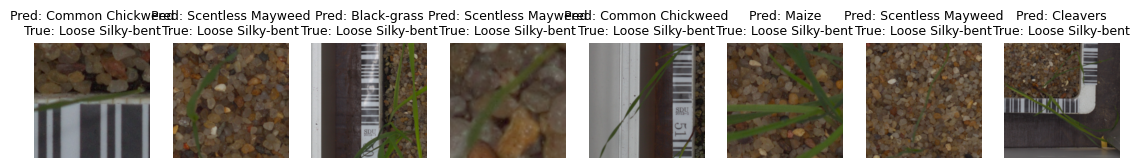

In [15]:

# Train!
trainer.fit(model, datamodule=data_module)

# Load the best model
best_model = CNNClassifier.load_from_checkpoint(checkpoint_cb.best_model_path, num_classes=num_classes)

# Evaluate on validation set
trainer.validate(best_model, datamodule=data_module)

batch = next(iter(data_module.val_dataloader()))
images, targets = batch
outputs = best_model(images)
preds = outputs.argmax(1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
class_names = os.listdir('data/split/train')
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1,8,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}", fontsize=9)
    plt.axis('off')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

Accuracy and Loss

In [24]:
# Get predictions and calculate metrics
best_model.eval()
best_model = best_model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Move model to correct device

all_preds = []
all_targets = []
total_loss = 0.0
total_samples = 0

criterion = nn.CrossEntropyLoss()  # Define loss function

with torch.no_grad():
    for batch in data_module.val_dataloader():
        images, targets = batch
        device = next(best_model.parameters()).device
        images, targets = images.to(device), targets.to(device)

        outputs = best_model(images)
        loss = criterion(outputs, targets)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Accumulate loss
        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Calculate metrics
accuracy = np.mean(all_preds == all_targets)
avg_loss = total_loss / total_samples

print(f"Validation Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Loss: {avg_loss:.4f}")

Validation Metrics:
Accuracy: 0.7944 (79.44%)
Loss: 0.7307


Sample Predictions

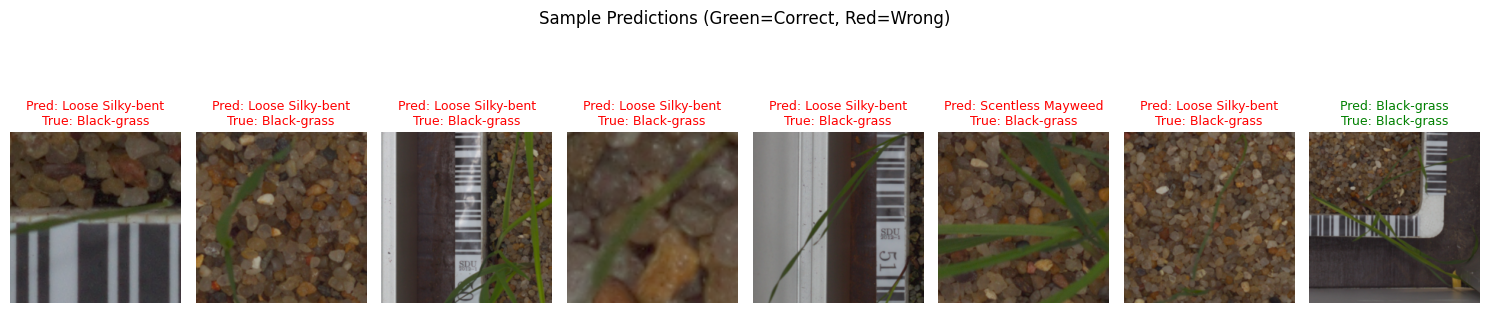

In [22]:
# Show some predictions
batch = next(iter(data_module.val_dataloader()))
images, targets = batch

# Move model and data to same device
device = next(best_model.parameters()).device  # Get device model is on
images = images.to(device)
targets = targets.to(device)

# Get predictions
outputs = best_model(images)
preds = outputs.argmax(1)

# Move images back to CPU for visualization
images = images.cpu()

plt.figure(figsize=(15, 4))
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

for i in range(min(8, len(images))):  # Ensure we don't exceed batch size
    img = images[i].permute(1, 2, 0) * IMAGENET_STD + IMAGENET_MEAN
    img = torch.clamp(img, 0, 1)

    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    color = 'green' if preds[i] == targets[i] else 'red'
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}",
             fontsize=9, color=color)
    plt.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)')
plt.tight_layout()
plt.show()

In [26]:
# Your current CNN code
# At the end, save results:
torch.save({
    'model_name': 'CNN',
    'accuracy': accuracy,
    'loss': avg_loss,
    'best_model_path': checkpoint_cb.best_model_path
}, 'cnn_results.pt')